# Analyse the user annotation

load the ovaries_binary_matrix file and wisualise some infomation

In [1]:
%matplotlib inline
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
PATH_BASE = './'
PATH_CSV_GENE_MATRIX = PATH_BASE + 'data_images/ovaries_binary_matrix.csv'
PATH_TXT_IMAGES = PATH_BASE + 'data_images/all_ovary_image_info_for_prague.txt'
PATH_CSV_GENE_MATRIX_EXT = PATH_BASE + 'results/ovaries_binary_matrix.csv'
PATH_CSV_IMAGES_GENE = PATH_BASE + 'results/all_ovary_image_info_gene_binary_matrix.csv'
# PATH_CSV_IMAGES_GENE_SHORT = 'results/all_ovary_image_info_gene_binary_matrix_short.csv'
# PATH_CSV_LOCATIONS = 'temporary/ovaries_locations.csv'

## Loading the csv with gene location matrix

In [3]:
df_gene = pd.read_csv(PATH_CSV_GENE_MATRIX)
print ('loaded records: %i with columns: %i' % (len(df_gene), len(df_gene.columns)))
print ('-> %s', df_gene.columns.tolist()[:10])
# print 'unique indexes:', len(df_gene.groupby(df_gene.index).first())

loaded records: 7895 with columns: 137
('-> %s', ['Gene ID', 'Flybase ID', 'Flybase name', 'Plate', 'pos', '1:2:stage1', '2:3:stage2_to_7', '3:4:stage8', '4:5:stage9', '5:6:stage10'])


In [4]:
cols = [re.sub(':\d+:', ':', c).replace('_', '') for c in df_gene.columns]
cols2 = [re.sub('\d+:\d+:', '', c).replace('_', ' ') for c in df_gene.columns]
print ('sizes: %i -> %i -> %i' % (len(df_gene.columns), len(set(cols)), len(set(cols2))))
# print ('ALL:', sorted(set(cols)))
TAGS = ['ubiquitous', 'follicle cell', 'border cell', 'nurse cell', 'germline cell', 'somatic cell']
for tag in TAGS:
    print ('Tag: %s >> %s' % (tag, repr([n for n in set(cols2) if tag in n])))

sizes: 137 -> 123 -> 53
Tag: ubiquitous >> ['ubiquitous signal at all stages', 'oocyte ubiquitous', 'germline cells ubiquitous', 'nurse cells ubiquitous', 'enrichment ubiquitous', 'follicle cells ubiquitous', 'ubiquitous signal']
Tag: follicle cell >> ['follicle cells overlaying the oocyte', 'posterior follicle cells', 'anterior follicle cell', 'squamous follicle cells', 'centripetally migrating follicle cells', 'follicle cells ubiquitous', 'anterior follicle cells', 'follicle cells']
Tag: border cell >> ['border cells']
Tag: nurse cell >> ['nurse cells perinuclear', 'nurse cells nuclear foci', 'nurse cells ubiquitous', 'nurse cells', 'presumptive nurse cells']
Tag: germline cell >> ['germline cells ubiquitous', 'germline cells']
Tag: somatic cell >> ['somatic cells']


remove a mubering from middle of the each column name

In [5]:
# df_gene.columns = [re.sub(':\d+:', ':', c) for c in df_gene.columns]
# df_gene.head()

duplicate colums with "all stages" to such colmns

In [6]:
df_gene.columns = [c.replace('_', ' ') for c in df_gene.columns]
for c in (c for c in df_gene.columns if 'at all stages' in c):
    c_base = c.replace('at all stages', '').rstrip()
    for sg in range(6):
        df_gene[str(sg) + c_base[1:]] = df_gene[c]
    del df_gene[c]

In [7]:
# the identification of key columns
COL_HEAD = ['Gene ID', 'Flybase ID', 'Flybase name', 'Plate', 'pos']
# cleaned lost of columns
COL_LABEL = [c for c in df_gene.columns 
             if c not in COL_HEAD and re.match('\d+:', c) 
             and all(ci not in c for ci in [':stage', 'at all stages', 'misc'])]
# unique columns labels
COL_LABEL_UQ = list(set([re.sub('\d+:\d+:', '', c).replace('cells', 'cell') for c in COL_LABEL]))
print (COL_LABEL_UQ)

['border cell', 'perinuclear', 'follicle cell', 'oocyte ubiquitous', 'cytoplasmic foci', 'germline cell ubiquitous', 'apical restriction', 'nurse cell ubiquitous', 'terminal filament', 'cystoblast', 'squamous follicle cell', 'oocyte', 'anterior restriction', 'posterior restriction', 'escort cell', 'ubiquitous signal', 'enrichment ubiquitous', 'oocyte nucleus', 'follicle cell overlaying the oocyte', 'basal restrictrion', 'centripetally migrating follicle cell', 'anterior follicle cell', 'interesting pattern', 'posterior follicle cell', 'presumptive nurse cell', 'nurse cell nuclear foci', 'interfollicular stalk cell', 'germline stem cell', 'presumptive oocyte', 'germline cell', 'somatic cell', 'nurse cell perinuclear', 'cap cell', 'follicle stem cell', 'nuclear foci', 'no signal', 'nurse cell', 'cortical enrichment', 'follicle cell ubiquitous']


transform the label matrix -> all posibla labels over all stages and have stage as a parameters

In [8]:
def parse_row(idx_row):
    idx, row = idx_row
    rrow = dict(row[COL_HEAD])
    # iterate over all stages 1, ..., 5
    r_gene = []
    for sg in range(1, 6):
        rrow_l = rrow.copy()
        rrow_l['stage'] = sg
        for l_uq in COL_LABEL_UQ:
            # agregate over all colums with the unique column name
            ll = [l for l in COL_LABEL if re.match(str(sg) + ':\d+:' + l_uq, l)]
            val = max(row[ll]) if len(ll) > 0 else 0
            rrow_l[l_uq] = val
        r_gene.append(rrow_l)
    return r_gene

In [28]:
l_gene = []
for idx, row in tqdm.tqdm(df_gene.iterrows(), desc='parse gene rows'):
    l_gene += parse_row([idx, row])
    
# import bpdl.utilities as utils
# l_gene = []
# for r_gene in utils.wrap_execute_sequence(parse_row, df_gene.iterrows(), nb_jobs=4, desc='parse gene rows'):
#     l_gene += parse_row([idx, row])

# create the DF
df_gene_ext = pd.DataFrame(l_gene)
df_gene_ext.to_csv(PATH_CSV_GENE_MATRIX_EXT, index=False)
# df_gene_ext.head()

parse gene rows: 7895it [11:46, 12.19it/s]


## Genes appers in particular stages

In [9]:
df_gene_ext = pd.read_csv(PATH_CSV_GENE_MATRIX_EXT, index_col=None)
l_stat = []
for sg, dfg in df_gene_ext.groupby('stage'):
    stat = dict(dfg.sum())
    stat['stage'] = sg
    l_stat.append(stat)
df_stat = pd.DataFrame(l_stat).set_index('stage')
df_stat.to_csv('temp-statistic_oavry-label.csv')
del df_stat['pos']

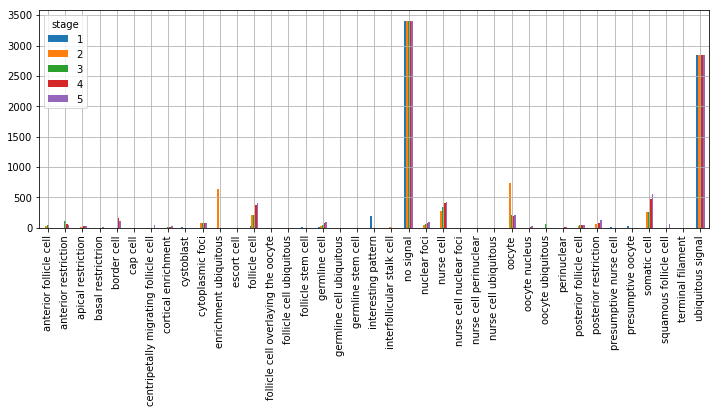

In [10]:
_= df_stat.T.plot.bar(figsize=(12, 4), grid=True)

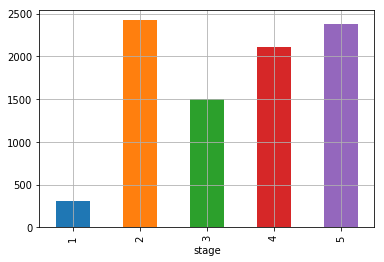

In [11]:
df_stat_sr = df_stat.copy()
del df_stat_sr['no signal']
del df_stat_sr['ubiquitous signal']
_= df_stat_sr.T.sum().plot.bar(figsize=(6, 4), grid=True)

In [12]:
df_gene_ext = pd.read_csv(PATH_CSV_GENE_MATRIX_EXT, index_col=None)
TAGS = ['follicle cell', 'border cell', 'nurse cell', 'germline cell', 'somatic cell']
l_stat = []
for sg, dfg in df_gene_ext.groupby('stage'):
    stat = {'stage': sg}
    for tag in TAGS:
        ll = [c for c in df_gene_ext.columns if tag in c]
        stat[tag] = np.sum(dfg[ll].sum())
    l_stat.append(stat)
df_stat_tag = pd.DataFrame(l_stat).set_index('stage')
df_stat_tag.to_csv('temp-statistic2_oavry-label.csv')

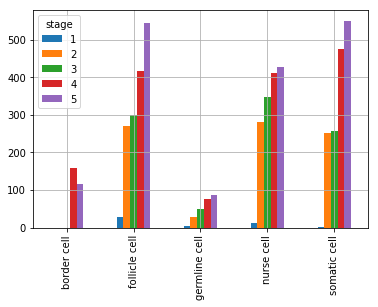

In [13]:
_= df_stat_tag.T.plot.bar(figsize=(6, 4), grid=True)

## Loading the txt file with all imges and used genes

In [14]:
df_images = pd.read_csv(PATH_TXT_IMAGES, sep='\t')
# df_images['id'] = df_images.index
# df_images.reset_index(drop=True, inplace=True)
print ('loaded records: %i with columns:\n %s' % (len(df_images), df_images.columns.tolist()))

loaded records: 34282 with columns:
 ['id', 'est_id', 'gene_id', 'fbgn', 'cgname', 'stage', 'image_id', 'image_path', 'ant_x', 'ant_y', 'post_x', 'post_y', 'lat_x', 'lat_y', 'slice_index', 'stack_path']


In [15]:
df_images.head(3)

,id,est_id,gene_id,fbgn,cgname,stage,image_id,image_path,ant_x,ant_y,post_x,post_y,lat_x,lat_y,slice_index,stack_path
0,448,LD17129-dg,CG6605,FBgn0000183,CG6605,1,1,insitu1.tif,193,935,452,587,236,720,19,MD-Experiment-2011-04-15-11971_Position(23).zvi
1,448,LD17129-dg,CG6605,FBgn0000183,CG6605,1,2,insitu2.tif,367,798,606,882,509,799,28,MD-Experiment-2011-04-15-11971_Position(20).zvi
2,448,LD17129-dg,CG6605,FBgn0000183,CG6605,1,3,insitu3.tif,305,990,396,801,293,864,22,MD-Experiment-2011-04-15-11971_Position(6).zvi


## Fuse those two tables together

In [16]:
df_gene_ext['Plate'] = [v.replace('.', '') for v in df_gene_ext['Plate']]
df_images['Plate'] = [re.split('[ _\-]+', v)[0] for v in df_images['stack_path']]

In [17]:
COLS_IMAGES = ['stage', 'fbgn', 'cgname', 'Plate']
print ('uq. images rows: %i' % len(df_images.drop_duplicates(COLS_IMAGES)))
COLS_GENE = ['stage', 'Flybase ID', 'Gene ID', 'Plate']
print ('uq. gene rows: %i' % len(df_gene_ext.drop_duplicates(COLS_GENE)))
df_fuse = pd.merge(df_images, df_gene_ext.drop_duplicates(COLS_GENE), 
                   left_on=COLS_IMAGES, right_on=COLS_GENE, how='inner')
# df_fuse = pd.merge(df_images, df_gene_ext, 
#                    left_on=COLS_IMAGES, right_on=COLS_GENE, how='inner')
print ('Fusion %i + %i -> %i' % (len(df_images), len(df_gene_ext), len(df_fuse)))
df_fuse['label count'] = df_fuse[COL_LABEL_UQ].T.sum()
df_fuse.to_csv(PATH_CSV_IMAGES_GENE)

uq. images rows: 5376
uq. gene rows: 39405
Fusion 34282 + 39475 -> 26039


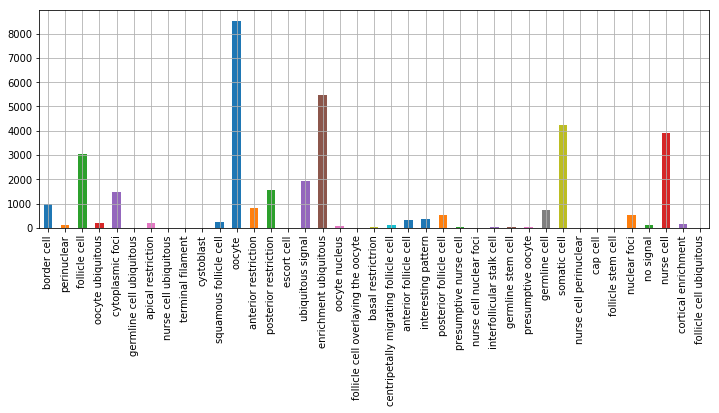

In [18]:
_= df_fuse[COL_LABEL_UQ].sum().plot.bar(figsize=(12, 4), grid=True)

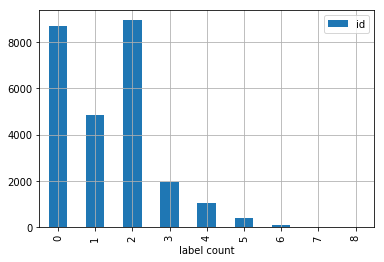

In [19]:
_= df_fuse[['label count', 'id']].groupby('label count').count().plot.bar(grid=True)

# Copy sample images grouoed by labels

In [21]:
PATH_IMAGES_IMGS = '/datagrid/Medical/microscopy/drosophila/ovary_selected_images'
PATH_IMAGES_SEGS = '/datagrid/Medical/microscopy/drosophila/RESULTS/PIPELINE_ovary_all_images/1_init_tissue_segmentation-vBFlach'

In [66]:
def compute_folder_histograms(path_imgs, df_dir_stat, path_segs=None, nb_max=None, nb_bins=50):
    d_hists = {}
    for n in tqdm.tqdm(df_dir_stat.index[:nb_max]):
        lp_images = sorted(glob.glob(os.path.join(path_imgs, n, '*')))
        if len(lp_images) == 0:
            continue
        hists = []
        for p_img in lp_images:
            im = plt.imread(p_img)[:, :, 1]
            if path_segs is None:
                seg = np.ones(im.shape)
            else:
                p_seg = os.path.join(path_segs, os.path.splitext(os.path.basename(p_img))[0] + '.png')
                if not os.path.isfile(p_seg):
                    continue
                seg = plt.imread(p_seg) > 0
            hg, b = np.histogram(im[seg > 0].ravel(), bins=nb_bins)
            hg = (hg / float(np.sum(hg)))
            hists.append(hg)
        if len(hists) > 0:
            bins = (b[1:] + b[:-1]) / 2.
            d_hists[n] = hists
    return d_hists, bins

In [67]:
def show_folder_histograms(d_hists, bins, nb_cols=4):
    nb_rows = int(np.ceil(len(d_hists) / float(nb_cols)))
    fig, axarr = plt.subplots(ncols=3, nrows=n_fcols, figsize=(nb_cols * 4, nb_rows * 3))
    for i, n in enumerate(d_hists):
        ax = axarr[int(i / nb_cols), i % nb_cols]
        ax.set_title(n), ax.grid()
        ax.semilogy(bins / np.max(bins), np.array(d_hists[n]).T)
        ax.set_xlabel('gene intensity')
        # plt.xticks(range(75)[::5], [str(round(b * 255)) for b in bins[::5]])
    fig.tight_layout()

### Copy Images with single tag

In [23]:
PATH_IMAGES_OUT_1 = '/datagrid/Medical/microscopy/drosophila/TEMPORARY/annot-user-labels-1'

df_fuse_1 = df_fuse[df_fuse['label count'] == 1]
# print ('found: %i' % len(df_fuse_1))
for lb in tqdm.tqdm(COL_LABEL_UQ, desc='labels'):
    df_lb = df_fuse_1[df_fuse_1[lb] == 1]
    path_lb = os.path.join(PATH_IMAGES_OUT_1, lb)
    if not os.path.isdir(path_lb):
        os.mkdir(path_lb)
    for idx, row in df_lb.iterrows():
        p_img_in = os.path.join(PATH_IMAGES_IMGS, row['image_path'])
        p_img_out = os.path.join(path_lb, os.path.splitext(row['image_path'])[0] + '.png')
        if os.path.isfile(p_img_in) and not os.path.isfile(p_img_out):
            plt.imsave(p_img_out, plt.imread(p_img_in))
            # shutil.copy(p_img_in, p_img_out)

labels: 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]


In [24]:
l_dirs = [{'label': os.path.basename(p), 'count': len(glob.glob(os.path.join(p, '*')))} 
          for p in glob.glob(os.path.join(PATH_IMAGES_OUT_1, '*')) if os.path.isdir(p)]
df_dir_stat_1 = pd.DataFrame(l_dirs).set_index('label').sort_values('count', ascending=False)
df_dir_stat_1[df_dir_stat_1['count'] > 0]

,count
label,
nurse cell,2280
ubiquitous signal,1906
interesting pattern,320
no signal,100
germline cell,84
somatic cell,42
oocyte,27
follicle cell,26
presumptive oocyte,18


In [26]:
d_hists_1, bins_1 = compute_folder_histograms(PATH_IMAGES_OUT_1, df_dir_stat_1)

100%|██████████| 39/39 [02:59<00:00,  4.61s/it]


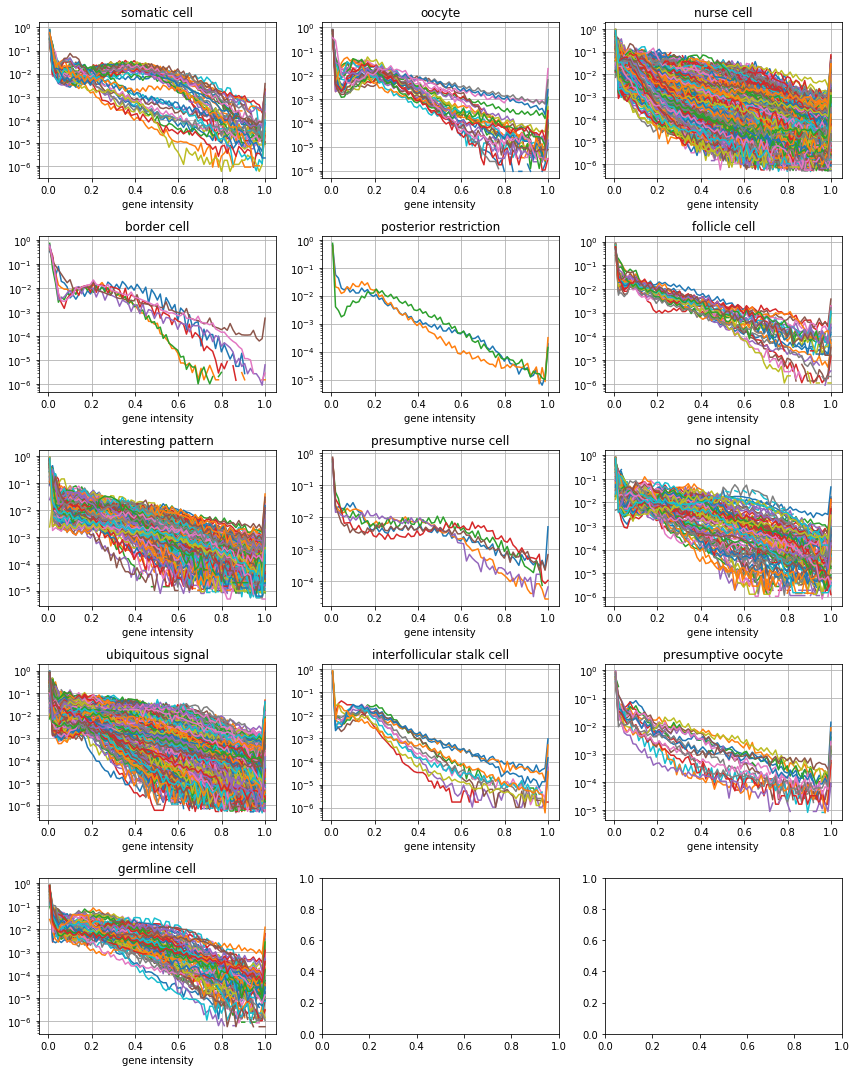

In [56]:
show_folder_histograms(d_hists_1, bins_1)

### Copy Images with double tag

In [57]:
PATH_IMAGES_OUT_2 = '/datagrid/Medical/microscopy/drosophila/TEMPORARY/annot-user-labels-2'

df_fuse_2 = df_fuse[df_fuse['label count'] == 2]
# print ('found: %i' % len(df_lb_2))
for idx, row in tqdm.tqdm(df_fuse_2.iterrows(), desc='images'):
    lbs = sorted([lb for lb in COL_LABEL_UQ if row[lb] == 1])
    path_lb = os.path.join(PATH_IMAGES_OUT_2, ' --- '.join(lbs))
    if not os.path.isdir(path_lb):
        os.mkdir(path_lb)
    p_img_in = os.path.join(PATH_IMAGES_IMGS, row['image_path'])
    p_img_out = os.path.join(path_lb, os.path.splitext(row['image_path'])[0] + '.png')
    if os.path.isfile(p_img_in) and not os.path.isfile(p_img_out):
        plt.imsave(p_img_out, plt.imread(p_img_in))
        # shutil.copy(p_img_in, p_img_out)

images: 8925it [00:08, 1091.77it/s]


In [58]:
l_dirs = [{'label': os.path.basename(p), 'count': len(glob.glob(os.path.join(p, '*')))} 
          for p in glob.glob(os.path.join(PATH_IMAGES_OUT_2, '*')) if os.path.isdir(p)]
df_dir_stat_2 = pd.DataFrame(l_dirs).set_index('label').sort_values('count', ascending=False)
df_dir_stat_2[df_dir_stat_2['count'] > 0]

,count
label,
enrichment ubiquitous --- oocyte,4864
oocyte --- posterior restriction,1213
follicle cell --- somatic cell,1066
anterior restriction --- oocyte,652
cytoplasmic foci --- nurse cell,283
border cell --- somatic cell,180
oocyte --- oocyte ubiquitous,169
cytoplasmic foci --- oocyte,130
oocyte --- oocyte nucleus,54


In [68]:
d_hists_2, bins_2 = compute_folder_histograms(PATH_IMAGES_OUT_2, df_dir_stat_2, path_segs=PATH_IMAGES_SEGS)

100%|██████████| 28/28 [04:44<00:00,  3.50it/s]


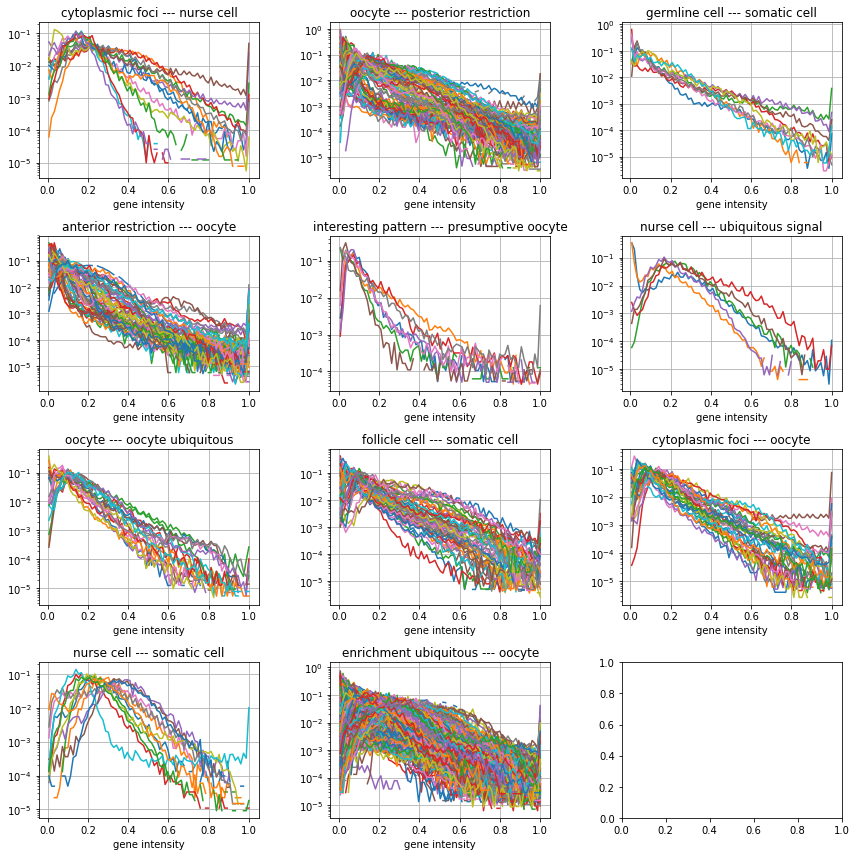

In [69]:
show_folder_histograms(d_hists_2, bins_2)